# Sepsis Prediction with Machine Learning

## Busines Understanding

Did you know that the founder of Jack Daniels died of Sepsis?

Sepsis is a medical term which refers to any “generalized inflammatory response associated with a serious infection”. This lethal transmitted response occurs when the host's response to infection, systemic and severe inflammation of the body, causes damage to its own tissues and organs. It is accompanied by a cytokine shock1.
It is a potentially life-threatening condition that arises when the body's response to infection causes injury to its own tissues and organs. Risk factors include:
 
- being very young or old
- a weakened immune system from conditions such as cancer or diabetes, major trauma, and burns.

(Source : [Wikipedia](https://en.wikipedia.org/wiki/Sepsis))

### Dataset

1. **Column Name	Attribute/Target	Description**
1. **ID:** N/A	Unique number to represent patient ID
2. **PRG :**	Attribute1	Plasma glucose
3. **PL :** Attribute 2	Blood Work Result-1 (mu U/ml)
4. **PR :**	Attribute 3	Blood Pressure (mm Hg)
5. **SK :**	Attribute 4	Blood Work Result-2 (mm)
6. **TS :**	Attribute 5	Blood Work Result-3 (mu U/ml)
7. **M11 :**	Attribute 6	Body mass index (weight in kg/(height in m)^2)
8. **BD2 :**	Attribute 7	Blood Work Result-4 (mu U/ml)
9. **Age :**	Attribute 8	patients age (years)
10. **Insurance :**	N/A	If a patient holds a valid insurance card
11. **Sepsis :**	Target	Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise


### Goal
1. Build a Machine Learning to predict Sepsis for ICU Patients
2. Build API using Fast API to embed the ML model

### Hypothesis

**Null Hypothesis (H0)**:
"There is no significant relationship between sepsis and PRG (Plasma/glucose)."

**Alternative Hypothesis (Ha)**:
"There is a significant relationship between sepsis and PRG (Plasma /glucose)."


### Analytical Questions

1. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?

2. What is the correlation between blood pressure (PR) and the likelihood of sepsis development?

3. Are there any noticeable differences in body mass index (M11) between patients with and without sepsis?

4. How does age vary between patients who develop sepsis and those who don't?

5. Is there a pattern in the blood work results (PL, SK, TS, BD2) that distinguishes patients with sepsis from those without?

## Data Understanding

### Import Libraries/Packages

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# EDA (pandas-profiling, etc. )
from statsmodels.genmod.families import Binomial
from scipy.stats import pointbiserialr
import scipy.stats as stats

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import RandomizedSearchCV

# Other packages
import os, joblib
from joblib import load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Data Loading

In [2]:
df = pd.read_csv('Dataset/Patients_Files_Train.csv')
df.head() # preview the data

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [3]:
# view basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [4]:
# Let's view some statistics from our dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


In [5]:
# check if our data has null values
df.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [6]:
#check for duplicates
df.duplicated().sum()

0

In [7]:
df['Insurance'].unique()

array([0, 1], dtype=int64)

- `Insurance` column 2 values

In [8]:
#Let's check unique values in the target
df['Sepssis'].unique()

array(['Positive', 'Negative'], dtype=object)

#### Hypothesis Testing

**Null Hypothesis (H0)**:
"There is no significant relationship between sepsis and PRG (Plasma glucose)."

**Alternative Hypothesis (Ha)**:
"There is a significant relationship between sepsis and PRG (Plasma glucose)."

We want to find the correlation between Sepsis and PRGs. Since sepsis is a binary outcome, we want to use a **point-biserial** correlation coefficient and assess its significance using a correlation test.


In [9]:
# 'Sepsis' should be a binary variable (0 for negative, 1 for positive)

df_copy = df.copy()
df_copy['Sepssis'] = df_copy['Sepssis'].replace({'Negative': 0, 'Positive': 1})

# Calculate point-biserial correlation coefficient
correlation_coefficient, p_value = stats.pointbiserialr(df_copy['Sepssis'], df_copy['PRG'])

# Print the results
print(f"Point-Biserial Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Set the significance level (5%)
alpha = 0.05

# Determine if the correlation is statistically significant
if p_value < alpha:
    print("There is a significant correlation between sepsis and PRG.")
else:
    print("There is no significant correlation between sepsis and PRG.")

Point-Biserial Correlation Coefficient: 0.2071
P-value: 0.0000
There is a significant correlation between sepsis and PRG.


The **point-biserial correlation coefficient** is a measure of the strength and direction of association between a binary variable (in this case, the presence or absence of sepsis, coded as 0 or 1) and a continuous variable (Plasma glucose, PRG). The coefficient ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation.

- The correlation coefficient of 0.2071 suggests a **moderate positive correlation**. This positive value suggests a positive correlation between the presence of sepsis and the level of plasma glucose. In other words, as the value of plasma glucose increases, the likelihood of a patient developing sepsis also increases.

- The p-value of 0.0000 suggests that there is a strong statistical evidence to **reject the null hypothesis** (no correlation) in favor of the alternative hypothesis (significant correlation).

- This finding could have clinical implications, potentially suggesting that higher levels of plasma glucose may be associated with an increased risk of sepsis in the population. However, correlation does not imply causation, so further research and analysis would be needed to establish any causal relationship.

### Univariate Analysis
Here is the section to explore, analyze, visualize each variable independently of the others.

#### Distribution of Sepsis Data

In [10]:
sepsis_data = df['Sepssis'].value_counts()
sepsis_data

Sepssis
Negative    391
Positive    208
Name: count, dtype: int64

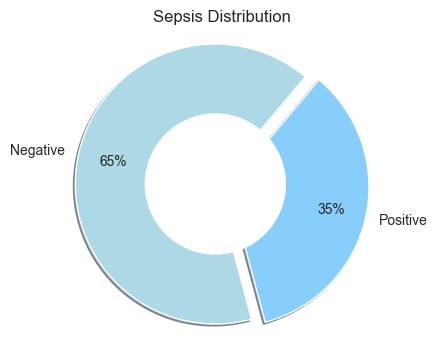

In [11]:
# Create a pie chart using pyplot to visulaize sepsis distribution

plt.figure(figsize=(4, 4))

plt.pie(sepsis_data, labels=['Negative','Positive'], colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Sepsis Distribution')
plt.show()

- More negative than positive cases of sepsis in our data
- The classes in the target variable are **imbalanced**. These need to be balanced before model training.

#### Distribution of Insurance Data

In [12]:
insurance_data = df['Insurance'].value_counts()
insurance_data

Insurance
1    411
0    188
Name: count, dtype: int64

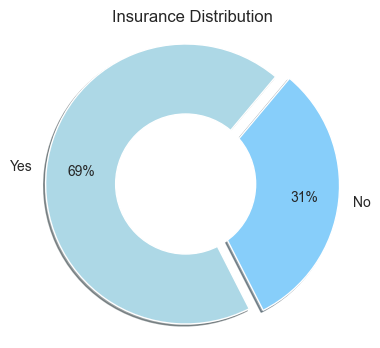

In [13]:
# Create a pie chart using pyplot to visulaize insurance distribution

plt.figure(figsize=(4, 4))

plt.pie(insurance_data, labels=['Yes','No'], colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Insurance Distribution')
plt.show()

- Most people have a health insurance cover

#### Distribution of other columns

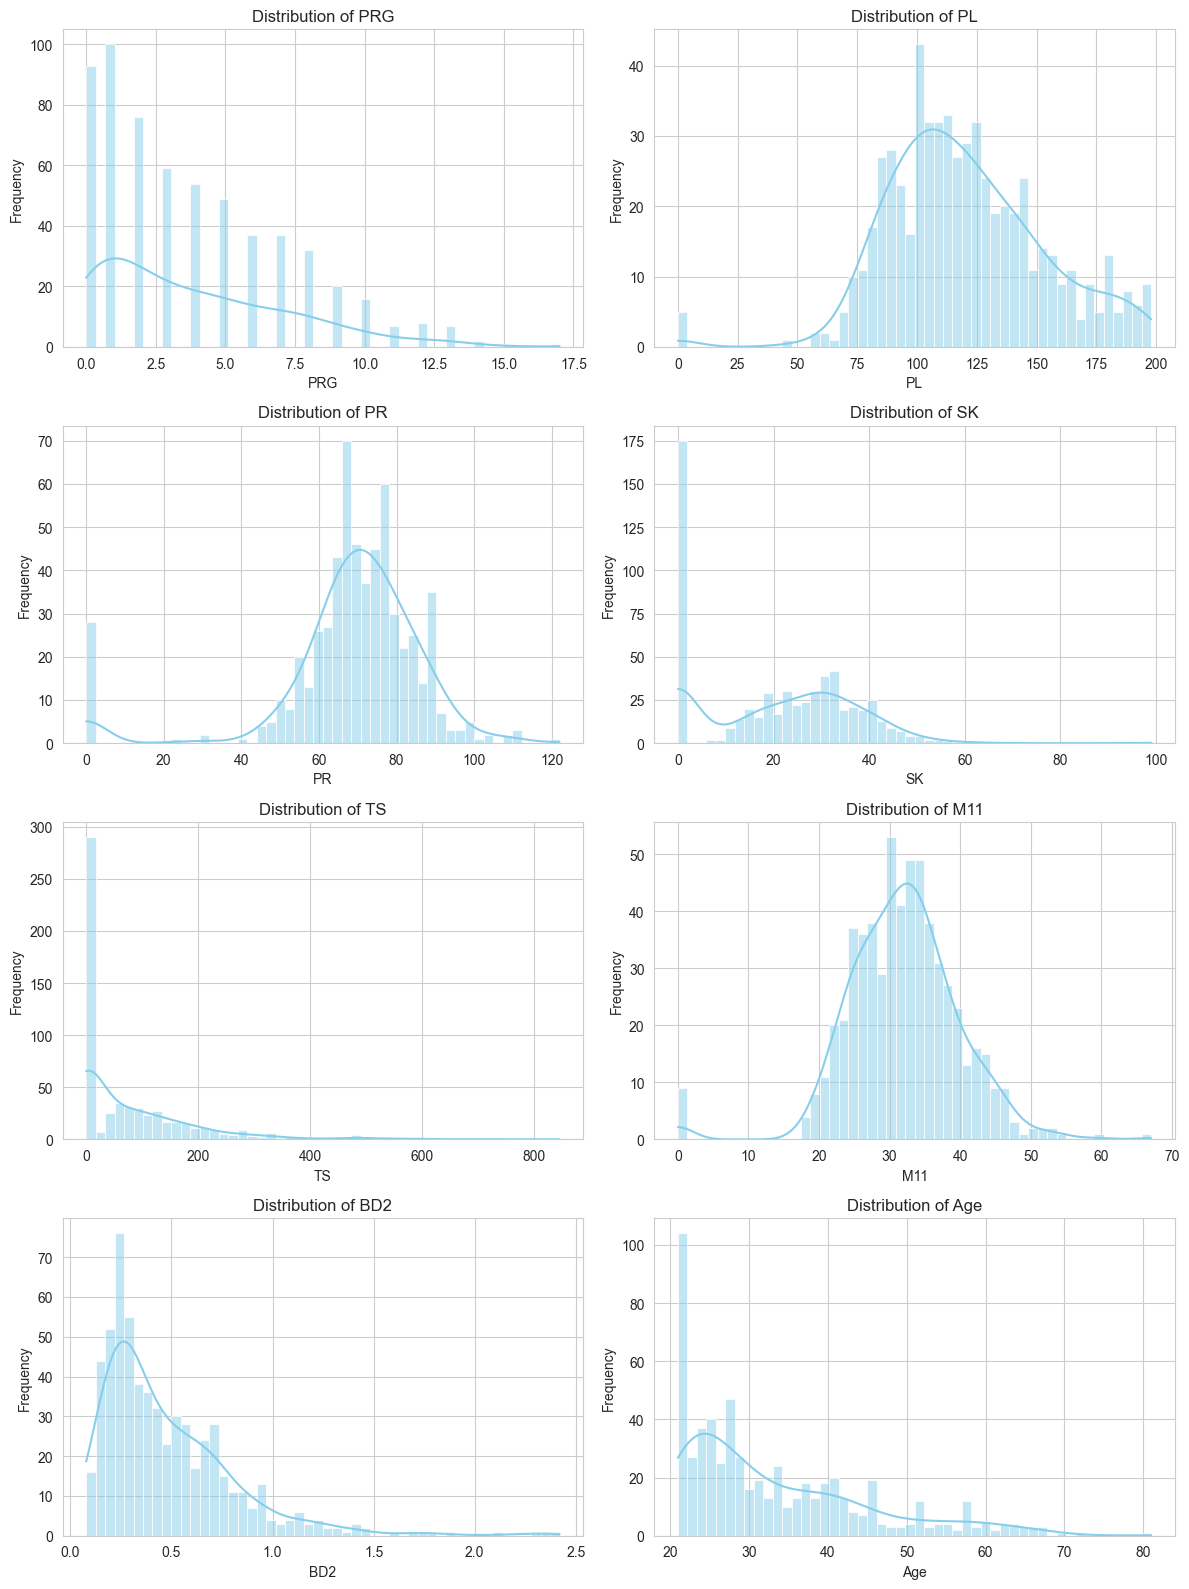

In [14]:
# Create histograms with KDE plots to visualize distribution of other columns

cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Calculate the number of rows needed
num_rows = len(cols) // 2 + len(cols) % 2

# Set up subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Iterate over columns and create histograms with KDE plots
for i, column in enumerate(cols):
    sns.histplot(df[column], kde=True, bins=50, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of subplots is odd
if len(cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


- KDE plots show us that standard measurements such as body mass index(M11) & Blood pressure seem to be normally distributed in the sample. This would make sense in a real life scenario.
- Blood work variables seem to vary, with majority being skewed right (positively skewed). This suggest the prescence of outliers in the upper bound of the dataset. The mean is larger than the median.

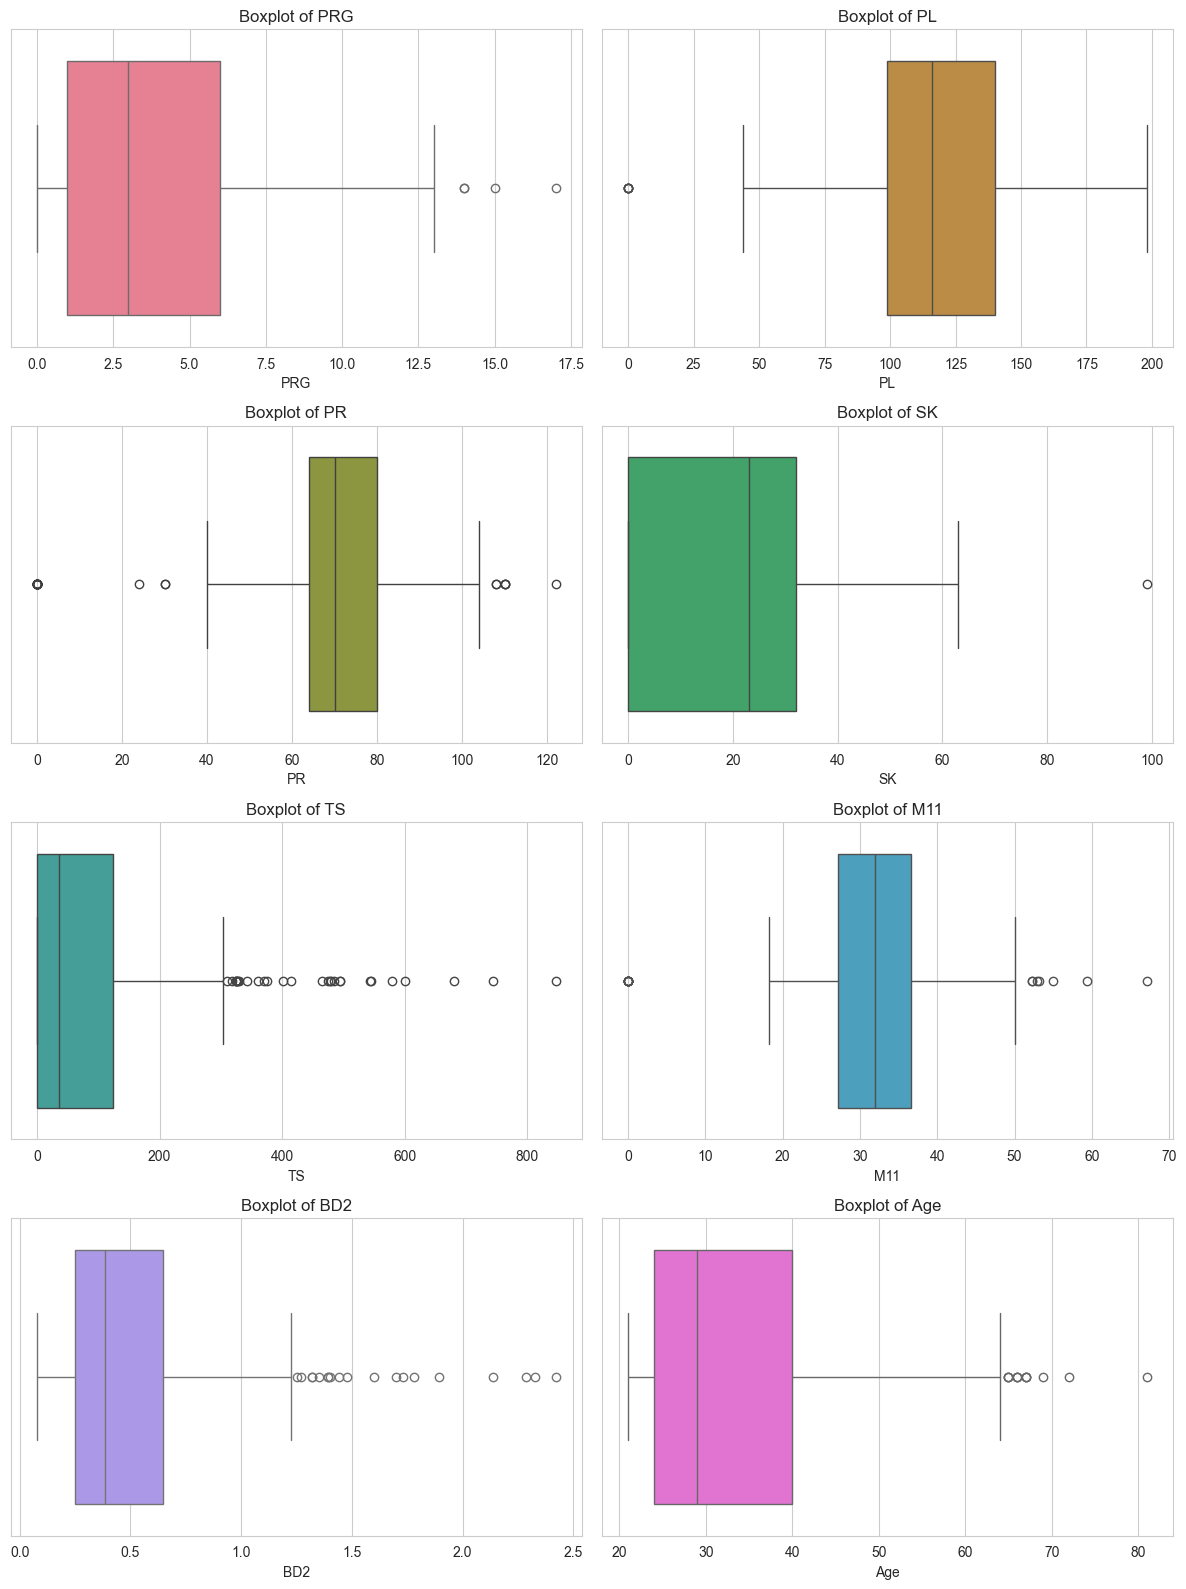

In [15]:
# Create box plots to visualize outliers

data_without = df.drop(['ID', 'Insurance'], axis=1)

# Identify numeric columns
numeric_columns = data_without.select_dtypes(include=['number']).columns

# Set up subplots
num_rows = len(numeric_columns) // 2 + len(numeric_columns) % 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 4 * num_rows))

# Flatten the 2D array of subplots for easier indexing
axes = axes.flatten()

# Define a color palette with different colors
colors = sns.color_palette("husl", n_colors=len(numeric_columns))

# Iterate over columns and create boxplots for numeric columns with different colors
for i, (column, color) in enumerate(zip(numeric_columns, colors)):
    sns.boxplot(x=data_without[column], ax=axes[i], orient='h', color=color)
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)

# Remove empty subplots if the number of subplots is odd
if len(numeric_columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

- We have outliers on all of our columns in our dataset. They mostly occur beyond the maximum value (upper bound) of the data. 

### Bi-variate Analysis

#### Analytical Questions

1. How is the distribution of plasma glucose (PRG) among patients who develop sepsis versus those who don't?

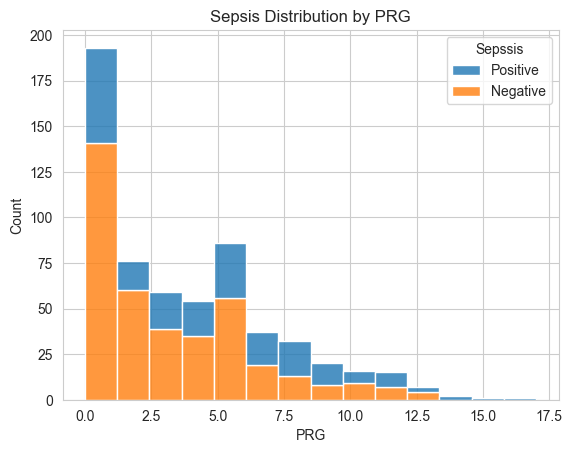

In [16]:
sns.histplot(x='PRG', hue='Sepssis', data=df, bins=14, alpha=0.8, multiple='stack')
plt.title('Sepsis Distribution by PRG')
plt.show()

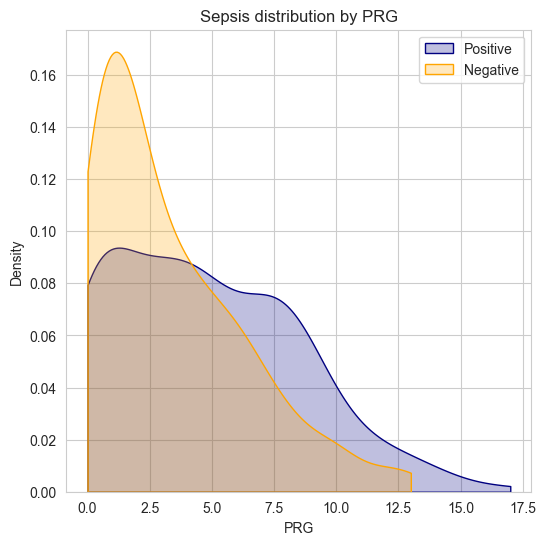

In [17]:
# We use a probability density distribution to show distribution of Sepsis related to PRG

def kdeplot(x):
    plt.figure(figsize=(6,6))
    plt.title('Sepsis distribution by PRG')
    ax0= sns.kdeplot(df[df['Sepssis'] == 'Positive'][x], color='navy', label='Sepssis:Yes', fill =True, cut=0)
    ax1= sns.kdeplot(df[df['Sepssis'] == 'Negative'][x], color='orange', label='Sepssis:No', fill=True, cut=0)
    plt.legend(['Positive', 'Negative'], loc='upper right')
kdeplot('PRG')

- There are more cases of sepsis among people with higher Plasma glucose (PRG).
- PRG of less than 4.0 has more negative cases of Sepsis

2. What is the correlation between blood pressure (PR) and the likelihood of sepsis development?

Correlation coefficient: 0.061086463680714534
P-value: 0.13535052825595778


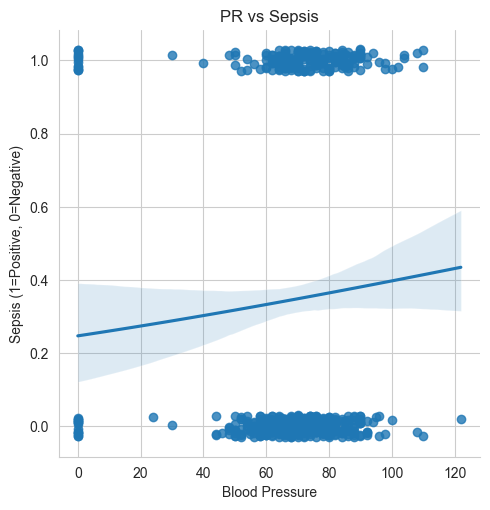

In [18]:
# Calculate the point-biserial correlation
corr, p_value = pointbiserialr(df_copy["PR"], df_copy["Sepssis"])

# Print the correlation coefficient and p-value
print("Correlation coefficient:", corr)
print("P-value:", p_value)

# Plot the data points and visualize
# logistic regression for binary dependent variable 

sns.lmplot(data=df_copy, x="PR", y="Sepssis", logistic=True, y_jitter=.03)
plt.xlabel("Blood Pressure")
plt.ylabel("Sepsis (1=Positive, 0=Negative)")
plt.title("PR vs Sepsis")
plt.show()

- The point biserial correlation is a specific type of correlation used when one variable is continuous (like blood pressure) and the other is dichotomous (like sepsis). The interpretation is generally similar to that of Pearson correlation.

- The positive correlation 0.061 suggests a weak positive relationship, meaning that higher blood pressure values are associated with a slightly higher likelihood of sepsis. However, a p-value of 0.135 suggests that the observed correlation may not be statistically significant at the 0.05 significance level

3. Are there any noticeable differences in body mass index (M11) between patients with and without sepsis?

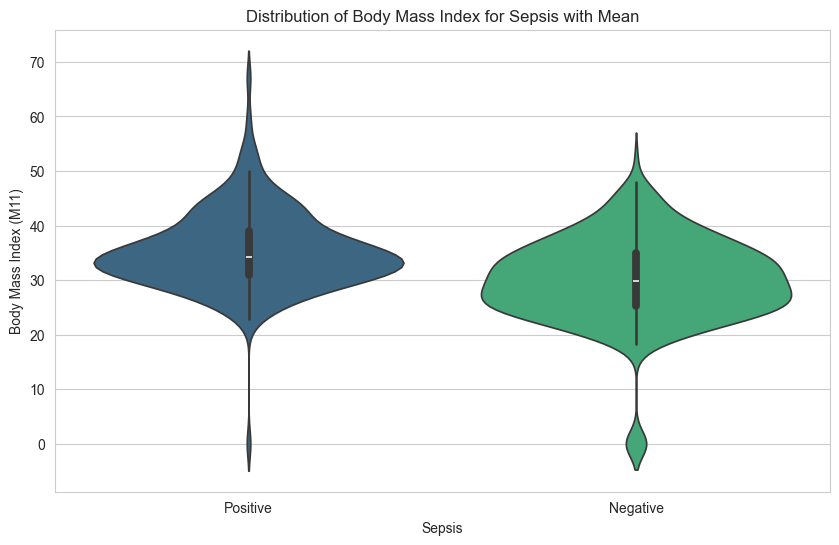

In [19]:
# Comparing the distribution of body mass index for patients in the two groups using violin plots.

plt.figure(figsize=(10, 6))
sns.violinplot(x=df['Sepssis'], y=df['M11'], palette='viridis')

# Set labels and title
plt.xlabel('Sepsis')
plt.ylabel('Body Mass Index (M11)')
plt.title('Distribution of Body Mass Index for Sepsis with Mean')
plt.show()


- Both BMI of positive and negative sepsis cases are concentrated around the median.
- Positive cases of sepsis coincide with a higher BMI than negative cases

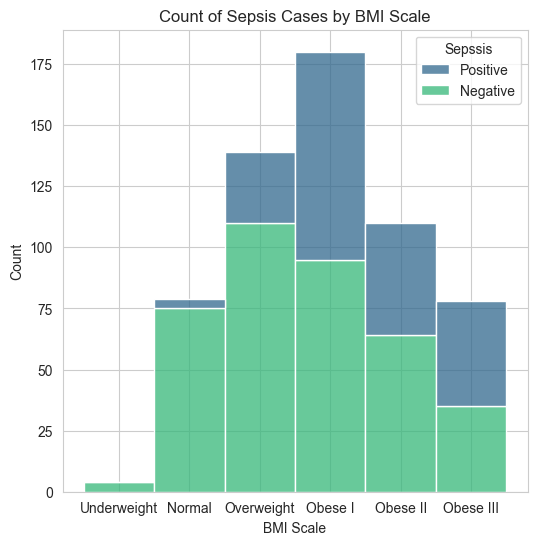

In [20]:
df_temp = df.copy()
df_temp['BMI_Scale'] = pd.cut(df['M11'], bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                    labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III'])

plt.figure(figsize=(6, 6))
sns.histplot(x='BMI_Scale', hue='Sepssis', data=df_temp, multiple='stack', palette='viridis')

# Set labels and title
plt.xlabel('BMI Scale')
plt.ylabel('Count')
plt.title('Count of Sepsis Cases by BMI Scale')

# Show the plot
plt.show()

- More patients with sepsis are overweight and obese. Fewer to no cases of sepsis with normal or underweight.
- Patients without sepsis are more likely to be normal weight or overweight. Negative cases start going down as BMI increases

4. How does age vary between patients who develop sepsis and those who don't?

In [21]:
df['Age'].describe()

count    599.000000
mean      33.290484
std       11.828446
min       21.000000
25%       24.000000
50%       29.000000
75%       40.000000
max       81.000000
Name: Age, dtype: float64

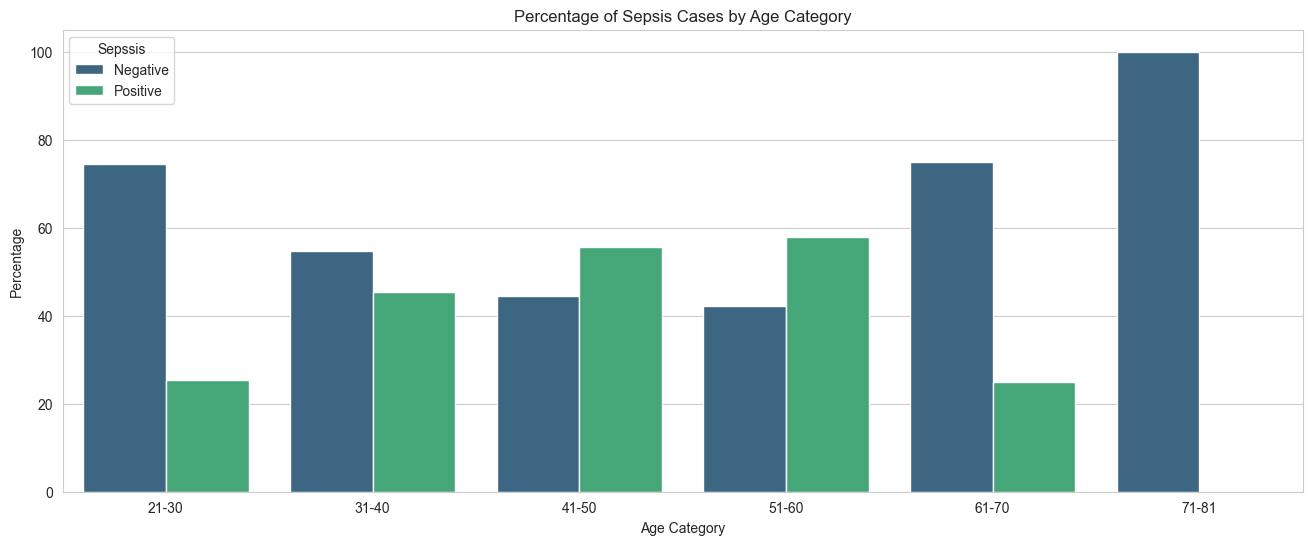

In [22]:
# Create a new column 'Age_Category' based on the 'Age' column
df_temp['Age_Category'] = pd.cut(df['Age'], bins=[21, 30, 40, 50, 60, 70, 81],
                            labels=['21-30', '31-40', '41-50', '51-60', '61-70', '71-81'])

# Create a DataFrame with percentage values
df_percentage = df_temp.groupby(['Age_Category', 'Sepssis']).size().unstack(fill_value=0)
df_percentage = df_percentage.div(df_percentage.sum(axis=1), axis=0) * 100

# Reshape DataFrame for seaborn
df_percentage = df_percentage.stack().reset_index(name='Percentage')

# Draw a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x='Age_Category', y='Percentage', hue='Sepssis', data=df_percentage, palette='viridis')

# Set labels and title
plt.xlabel('Age Category')
plt.ylabel('Percentage')
plt.title('Percentage of Sepsis Cases by Age Category')

# Show the plot
plt.show()

### Multivariate Analysis

5. Is there a pattern in the blood work results (PL, SK, TS, BD2) that distinguishes patients with sepsis from those without?

In [23]:
df_temp_2 =df_temp.copy()
df_temp_2.columns

Index(['ID', 'PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance',
       'Sepssis', 'BMI_Scale', 'Age_Category'],
      dtype='object')

In [24]:
df_temp_2['Sepssis'] = df_temp_2['Sepssis'].map({'Positive': 1, 'Negative': 0})

# Drop unwanted columns
df_temp_2 = df_temp_2.drop(['ID', 'PRG', 'PR', 'M11', 'Age', 'Insurance', 'BMI_Scale', 'Age_Category'], axis=1)

<Axes: >

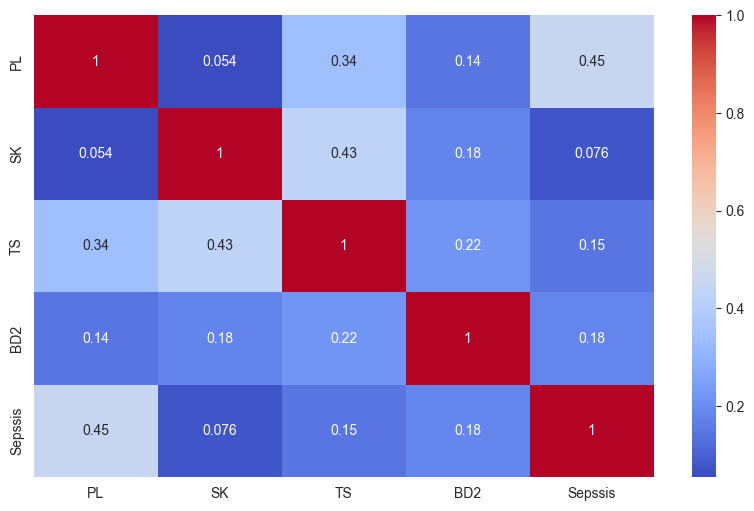

In [25]:
# Draw correlation matrix
correlation_matrix =df_temp_2.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')

- Pl (Attribute 2 Blood Work Result-1) = *0.4497* (**moderate positive correlation**)
Higher attribute 2 levels may be associated with a higher likelihood of sepsis.

- SK (Attribute 4 Blood Work Result-2) = *0.0756* (**very weak positive correlation**)
The correlation is close to zero, indicating a minimal linear relationship.

- TS (Attribute 5 Blood Work Result-3) = *0.1459* (**weak positive correlation**)
The correlation suggests a slight tendency for higher Blood Work Result-3 to be associated with a higher likelihood of sepsis.

- BD2 (Attribute 7 Blood Work Result-4) *0.1816* (**weak positive correlation**)
The correlation suggests a slight tendency for higher Blood Work Result-4 to be associated with a higher likelihood of sepsis.

## Data Preparation

In [27]:
df.tail()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
594,ICU200604,6,123,72,45,230,33.6,0.733,34,0,Negative
595,ICU200605,0,188,82,14,185,32.0,0.682,22,1,Positive
596,ICU200606,0,67,76,0,0,45.3,0.194,46,1,Negative
597,ICU200607,1,89,24,19,25,27.8,0.559,21,0,Negative
598,ICU200608,1,173,74,0,0,36.8,0.088,38,1,Positive


In [28]:
# Let's delete our ID column
df = df.drop(columns=['ID'],axis=1)
df.tail()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
594,6,123,72,45,230,33.6,0.733,34,0,Negative
595,0,188,82,14,185,32.0,0.682,22,1,Positive
596,0,67,76,0,0,45.3,0.194,46,1,Negative
597,1,89,24,19,25,27.8,0.559,21,0,Negative
598,1,173,74,0,0,36.8,0.088,38,1,Positive


In [29]:
# Rename column
df.rename(columns={'Sepssis': 'Sepsis'}, inplace=True)

In [30]:
#check for duplicated values
df.duplicated().value_counts()

False    599
Name: count, dtype: int64

### X and Y split

In [31]:
X =df.drop('Sepsis',axis=1)
X.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,6,148,72,35,0,33.6,0.627,50,0
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,1
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
y=df['Sepsis']
y.head()

0    Positive
1    Negative
2    Positive
3    Negative
4    Positive
Name: Sepsis, dtype: object

### Create Pipeline

In [33]:
input_features =X.columns
input_features

Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')

In [34]:
#column transformer - applying transformations to input features
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler',StandardScaler(),input_features),
        ('log_transformer',FunctionTransformer(np.log1p),input_features)
    ]
)

`StandardScaler`: This transformer scales the input features to have a mean of 0 and a standard deviation of 1. This is often beneficial for many machine learning algorithms, especially those that are sensitive to the scale of the input features, such as support vector machines (SVM) and k-nearest neighbors (KNN).

`log_transformer`: This transformer applies a logarithmic transformation to the input features using np.log1p. Logarithmic transformations are useful for dealing with skewed distributions, which are common in real-world datasets. In a classification task, this transformation might help normalize the distribution of the input features and improve the performance of the model, particularly if the features are positively skewed.

### Balance Target Classes

In [35]:
y.value_counts()

Sepsis
Negative    391
Positive    208
Name: count, dtype: int64

In [36]:
# apply SMOTE to the training data (oversampling)

smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy='auto')

X_resampled, y_resampled = smote.fit_resample(X, y)

Class imbalance is a common issue in classification tasks, where one class has significantly fewer samples than the other(s). This can lead to biased models that perform poorly on minority class instances. By applying `SMOTE`, we can generate synthetic samples for the minority class, thereby balancing the class distribution and improving the model's ability to generalize to unseen data.

In [38]:
# view class re-distribution

pd.value_counts(pd.Series(y_resampled))

Sepsis
Positive    391
Negative    391
Name: count, dtype: int64

### Train-Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [40]:
# check shape after resampling
pd.DataFrame(X_train).shape, pd.DataFrame(y_train).shape

((625, 9), (625, 1))

### Label Encoder

In [41]:
encoder =LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

Many machine learning algorithms require numerical input, including the target variable. `LabelEncoder` facilitates this transformation by converting categorical labels into a format that the algorithm can understand.

## Modeling

### 1. k-nearest neighbors (KNN)

In [42]:
# create and fit model

neighbors = KNeighborsClassifier()
pipeline_knn =Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('neighbors',neighbors)
])

pipeline_knn.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('neighbors', KNeighborsClassifier())])

In [43]:
knn_pred =pipeline_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test_encoded, knn_pred)
print(f"Accuracy: {accuracy_knn}")
print(classification_report(y_test_encoded,knn_pred))

Accuracy: 0.7261146496815286
              precision    recall  f1-score   support

           0       0.76      0.66      0.71        79
           1       0.70      0.79      0.74        78

    accuracy                           0.73       157
   macro avg       0.73      0.73      0.72       157
weighted avg       0.73      0.73      0.72       157



### 2. Logistic Regression

In [44]:
LR =LogisticRegression(solver='lbfgs',multi_class='auto')
pipeline_lr =Pipeline(steps=[
('preprocessor',preprocessor),
('LR',LR)
])

pipeline_lr.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('LR', LogisticRegression())])

In [45]:
LR_pred =pipeline_lr.predict(X_test)
# Check the accuracy
accuracy_lr = accuracy_score(y_test_encoded, LR_pred)
print(f"Accuracy: {accuracy_lr}")
print(classification_report(y_test_encoded,LR_pred))

Accuracy: 0.6942675159235668
              precision    recall  f1-score   support

           0       0.69      0.72      0.70        79
           1       0.70      0.67      0.68        78

    accuracy                           0.69       157
   macro avg       0.69      0.69      0.69       157
weighted avg       0.69      0.69      0.69       157



### 3. Decision Tree Classifier

In [46]:
# Model create
DTR =DecisionTreeClassifier()
#call pipeline
pipeline_dtr =Pipeline(steps=[
('preprocessor',preprocessor),
('DTR',DTR)
])

#train the model
pipeline_dtr.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('DTR', DecisionTreeClassifier())])

In [47]:
#predict the model
dtr_pred =pipeline_dtr.predict(X_test)
accuracy_dtr = accuracy_score(y_test_encoded, dtr_pred)
print(f"Accuracy: {accuracy_dtr}")
print(classification_report(y_test_encoded,dtr_pred))

Accuracy: 0.7579617834394905
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        79
           1       0.76      0.76      0.76        78

    accuracy                           0.76       157
   macro avg       0.76      0.76      0.76       157
weighted avg       0.76      0.76      0.76       157



### 4. XGB Classifier

In [48]:
# Create a model
XGB =XGBClassifier(objective='multi:softmax', num_class=3)

## call pipeline with model
pipeline_xgb =Pipeline(steps=[
('preprocessor',preprocessor),
('XGB',XGB)
])
# train our model
pipeline_xgb.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('XGB',
                 XGBClassifier(base_score=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

In [49]:
## predict the model
xbg_pred =pipeline_xgb.predict(X_test)

## print classification report
accuracy_xgb = accuracy_score(y_test_encoded, xbg_pred)
print(f"Accuracy: {accuracy_xgb}")
print(classification_report(y_test_encoded,xbg_pred))

Accuracy: 0.7834394904458599
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        79
           1       0.76      0.82      0.79        78

    accuracy                           0.78       157
   macro avg       0.79      0.78      0.78       157
weighted avg       0.79      0.78      0.78       157



### 5. Random Forest Classifier

In [50]:
# Create a model
RFC =RandomForestClassifier(n_estimators=100)

## call pipeline with model
pipeline_rfc =Pipeline(steps=[
('preprocessor',preprocessor),
('RFC',RFC)
])
# train our model
pipeline_rfc.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('RFC', RandomForestClassifier())])

In [51]:
## predict the model
rfc_pred =pipeline_rfc.predict(X_test)

## print classification report
accuracy_rfc = accuracy_score(y_test_encoded, rfc_pred)
print(f"Accuracy: {accuracy_rfc}")
print(classification_report(y_test_encoded,rfc_pred))

Accuracy: 0.7961783439490446
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        79
           1       0.77      0.83      0.80        78

    accuracy                           0.80       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.80      0.80      0.80       157



### 6. Support Vector Classifier (SVC)

In [52]:
# Create an instance of the SVC class
svc_model = SVC (gamma='scale')

# Call pipeline with the model
pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SVC', svc_model)
])

# train our model
pipeline_svc.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('SVC', SVC())])

In [53]:
## predict the model
svc_pred =pipeline_svc.predict(X_test)

## print classification report
accuracy_svc = accuracy_score(y_test_encoded, svc_pred)
print(f"Accuracy: {accuracy_svc}")
print(classification_report(y_test_encoded,svc_pred))

Accuracy: 0.7197452229299363
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        79
           1       0.72      0.72      0.72        78

    accuracy                           0.72       157
   macro avg       0.72      0.72      0.72       157
weighted avg       0.72      0.72      0.72       157



## Evaluation

In [54]:
# Create a dictionary for accuracy
accuracy_results = {
    'SVC': accuracy_svc,
    'RandomForest': accuracy_rfc,
    'XGB' :accuracy_xgb,
    'DTR':accuracy_dtr,
    'LR':accuracy_lr,
    'KNN':accuracy_knn
}

df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# show the result
df_sorted = df.sort_values(by='Accuracy', ascending=False)
df_sorted

,Model,Accuracy
1,RandomForest,0.796178
2,XGB,0.783439
3,DTR,0.757962
5,KNN,0.726115
0,SVC,0.719745
4,LR,0.694268


- Our best performing model is the `RandomForestClassifier` with 0.8 accuracy

In [55]:
confusion_matrix_rf = confusion_matrix(y_test_encoded, rfc_pred)
confusion_matrix_rf

array([[60, 19],
       [13, 65]], dtype=int64)

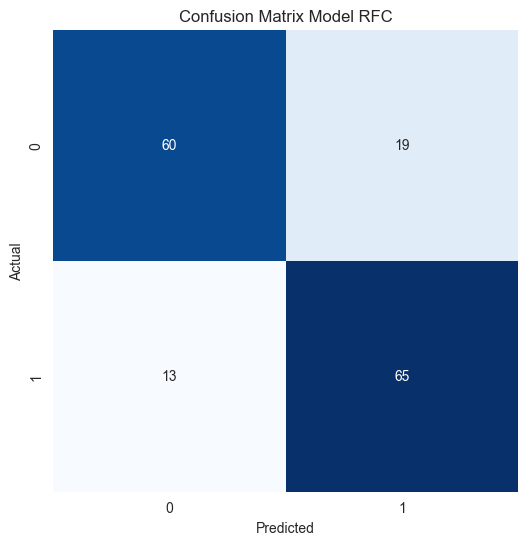

In [56]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model RFC')
plt.show()

- 60 instances were correctly classified as True Negatives (TN).
- 65 instances were correctly classified as True Positives (TP).
- 19 instances were classified as False Positives (FP).
- 13 instances were classified as False Negatives (FN).

### Hyperparameter tuning

In [57]:
# Check current model parameters
current_params = RFC.get_params()
current_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [77]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
}


# Initialize RandomizedSearchCV
random_search_rfc = RandomizedSearchCV(estimator=RFC, param_distributions=param_dist, scoring='accuracy',
                                     cv=10, n_jobs=-1, random_state=42, n_iter=150, verbose = 1)

# fit best estimator on train data
random_search_rfc.fit(X_train, y_train_encoded)

# best parameters
best_params = random_search_rfc.best_params_

# mean accuracy score of the best estimator
best_score = random_search_rfc.best_score_

best_params

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': True}

In [78]:
# mean accuracy score of the best estimator

best_score

0.8290066564260112

In [79]:
# Fit tuned model on train data
tuned_rfc_model = random_search_rfc.best_estimator_
tuned_rfc_model.fit(X_train, y_train_encoded)

# make the predictions
random_search_rfc_pred = tuned_rfc_model.predict(X_test)

In [80]:
# Calculate accuracy for the tuned XGBoost predictions
accuracy_tuned_rfc = accuracy_score(y_test_encoded, random_search_rfc_pred)

# Create DataFrames for saving accuracy metrics
metrics_df_original = pd.DataFrame({'Accuracy': [accuracy_rfc]}, index=['Original Random Forest Classifier'])
metrics_df_tuned = pd.DataFrame({'Accuracy': [accuracy_tuned_rfc]}, index=['Tuned Random Forest Classifier'])

# Concatenate the DataFrames vertically to combine the metrics
combined_metrics_df = pd.concat([metrics_df_original, metrics_df_tuned])

# Print the combined metrics DataFrame
print(combined_metrics_df)


                                   Accuracy
Original Random Forest Classifier  0.796178
Tuned Random Forest Classifier     0.789809


In [81]:
# construct the confusion matrix for tuned model
confusion_matrix_gb = confusion_matrix(y_test_encoded, random_search_rfc_pred)
confusion_matrix_gb

array([[59, 20],
       [13, 65]], dtype=int64)

- Model performance dropped slightly

### Export key components

In [82]:
destination = "toolkit"
#create a directory if it doesn't exist

if not os.path.exists(destination):
    os.makedirs(destination)
#Create a dictionary  to store the object and their filename
models ={
    "pipeline":pipeline_rfc,
    "encoder":encoder,
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)

### Predictions

In [83]:
df = pd.read_csv('Dataset/Patients_Files_Test.csv')
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [85]:
df = df.drop(columns=['ID'],axis=1)
df.tail()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
164,10,101,76,48,180,32.9,0.171,63,1
165,2,122,70,27,0,36.8,0.340,27,1
166,5,121,72,23,112,26.2,0.245,30,1
167,1,126,60,0,0,30.1,0.349,47,1
168,1,93,70,31,0,30.4,0.315,23,1


In [86]:
# Load the model
loaded_model = load('toolkit\pipeline.joblib')

# Predict the labels on the preprocessed test data using the trained model
predictions = loaded_model.predict(df)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_14560\733394888.py:2: SyntaxWarning: invalid escape sequence '\p'
  loaded_model = load('toolkit\pipeline.joblib')


In [87]:
# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predicted_Label'])
# Map the numerical predictions to 'no' and 'yes'
predictions_df['Predicted_Label'] = predictions_df['Predicted_Label'].map({0: 'Negative', 1: 'Positive'})

predictions_df.value_counts()

Predicted_Label
Negative           109
Positive            60
Name: count, dtype: int64

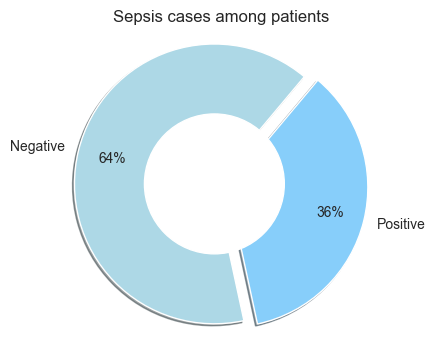

In [88]:
label_counts = predictions_df['Predicted_Label'].value_counts()

# Convert the counts to numeric values
count_values = label_counts.values
 
# Create a pie chart using pyplot to visulaize churn rate

plt.figure(figsize=(4, 4))

plt.pie(count_values, labels=label_counts.index, colors=['LightBlue','LightSkyBlue'], startangle=50, shadow=True, radius=2,
     explode=(0,0.2),autopct='%1.0f%%', pctdistance=0.75 ,  )
Circle=plt.Circle((0,0), 1, color='white')
c= plt.gcf()

c.gca().add_artist(Circle)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Sepsis cases among patients')
plt.show()